# Segmentación de tejido pulmonar


***
El presente notebook contiene una explicación detallada del proceso de segmentación de tejido pulmonar en imágenes de TC a partir de archivos DICOM, mediante el algoritmo de Watershed basado en marcadores.

## Objetivos

```
- Guardar imágenes de un examen de TC en un formato accesible y de fácil manejo en Python.
- Aplicar el algoritmo de Watershed basado en marcadores para segmentar pulmones.
- Segmentar tejido pulmonar en imágenes de Tomografía Computarizada de tórax.
- Implementar funciones que permitan automatizar procesos y eliminar código innecesario. 
- Graficar las imágenes segmentadas.

```

## Introducción

La segmentación constituye un paso importante previo al desarrollo de la mayoría de sistemas CAD (Diagnostico Asistido por Computadora) de identificación de enfermedades pulmonares. El proceso que se aplicará para la segmentación es un método automático que utiliza principalmente la transformación de Watershed basada en marcadores en 2D, con ciertas modificaciones que mejoran y delimitan de una manera más acertada los
pulmones, y que además fue descrito por primera vez en el artículo <a href="https://www.semanticscholar.org/paper/Automatic-lung-segmentation-in-CT-images-using-Shojaii-Alirezaie/03002d15a3af26c6d961286d4e039787622a8fbe">DOI:10.1109/ICIP.2005.1530294</a>. El desarrollo de la herramienta se fundamenta mayoritariamente en los códigos encontrados en el sitio web Kaggle, los links los puede encontrar en los siguietes enlaces <a href="https://www.kaggle.com/ankasor/improved-lung-segmentation-using-watershed"> link 1</a> y <a href="https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial"> link 2</a>. 




A continuación se presenta el flujo de trabajo para la segmentación pulmonar en imágenes DICOM de TC de tórax, este flujo de trabajo muestra la estructura que tiene el presente notebook.

<img src="imagenes/Flujo_segmentacion.png"> 
 

>**Nota**: Las funciones que se diseñaron para automatizar procesos y para que  el presente notebook sea mas interactivo y fácil de entender,  fueron guardadas en el archivo **`segmentacion_pulmonar.py`**, el archivo es importado como **`s_p`**.
Además se utilizará el módulo creado anteriormente para la visualización y manipulación de las imágenes DICOM llamado **`imprimir_imagen.py`** y es importado a este notebook como **`imp`**.

## Librerías y módulos


Las bibliotecas que son necesarias para este proyecto son las siguientes:


- *pydicom* para leer los atributos de archivos DICOM.
- *numpy* para la manipulación de las matrices.
- *matplotlib* para gráficar datos.
- *imprimir_imagen* para manipular imágenes de CT de archivos dicom.
- *scipy.ndimage* para el procesamiento de imágenes multidimensionales.
- *skimage* para procesamiento de imágenes
- *os* para manipulación de directorios
- *segmentacion_pulmonar* librería diseñada para automatizar los procesos de segmentación.

In [1]:
import pydicom
import numpy as np
import matplotlib.pylab as plt
import imprimir_imagen as imp
import scipy.ndimage as ndimage
import os
import segmentacion_pulmonar as s_p


from skimage import measure, morphology, segmentation

## Selección de exámenes (RADIOTERAPIA DE TÓRAX)

Para realizar la segmentación de tejido pulmonar se utilizaron los exámenes que comprenden la zona torácica, con este fin se realizó un filtraje de las imágenes por medio del atributo Protocol name con el tag (0018,1030), un atributo llenado por el operador con las condiciones bajo las cuales se realizó la serie, se eligió las imágenes con el elemento 10.7 RADIOTERAPIA TORAX, utilizadas en la planificación del tratamiento de radioterapia. También se utilizará el elemento 6.1 ABDOMEN Y PELVIS de un TC corporal.

## Lectura de la imagen
La lectura de los datos de un archivo DICOM para la segmentación sigue el mismo proceso que se realizó para la visualización, así mismo se extrae algunos atributos que son necesarios para la reconstrucción de la imagen, todo este proceso lo puede encontrar en el notebook de Jupyter  <a href="https://github.com/jennifer95/visualizacion-segmentancion-pulmonar-DICOM-python/blob/main/Visualizaci%C3%B3n%20de%20im%C3%A1genes%20DICOM.ipynb">Visualización de imágenes DICOM.ipynb</a>. En el archivo **`imprimir_imagen.py`** se diseñaron funciones que permiten realizar todo este proceso de una manera muy simplificada, automática y mediante el uso de funciones.


## Obtención, transformación de unidades y corrección de la matriz N × M × M
En esta sección se obtiene una matriz de N × M × M dimensiones producto de la lectura de la matriz de píxeles de cada uno de los archivos DICOM de un mismo examen y de su posterior apilamiento, a la cual  llamamos matriz 3D, luego se realiza el cambio de unidades a Hounsfield y finalmente se lleva a cabo la corrección de píxeles,
de una manera similar a la que se realizó para el proceso de visualización.


In [2]:
ruta = 'datos-torax-A/paciente3-A' # ruta de la imagen
imagen = imp.extrac_matrix(imp.load_scan(ruta)) # cargamos las imágenes y extraemos la matriz
print('La matriz tiene las dimensiones de ' ,imagen.shape, 'lo que representa ', imagen.shape[0], 
      'cortes e imágenes de ', imagen.shape[1],'x',imagen.shape[2])

La matriz tiene las dimensiones de  (63, 512, 512) lo que representa  63 cortes e imágenes de  512 x 512


## Almacenamiento de la matriz

 La matriz de píxeles será almacenada en el formato NPY, un tipo de archivo de matriz NumPy creado por el paquete de software Python con la biblioteca NumPy.

In [3]:
try:
    os.mkdir('arrays') # crea una carpeta en la misma carpeta donde esta el notebook jupyter
except:
    print("La carpeta ya existe")
ruta_arrays = 'arrays/'
np.save(ruta_arrays + "arrays_{}.npy" .format('paciente3-A'), imagen) # almacenamos en NPY
imagen_procesada = np.load(ruta_arrays+'arrays_{}.npy'.format('paciente3-A')) # cargamos la matriz    

La carpeta ya existe


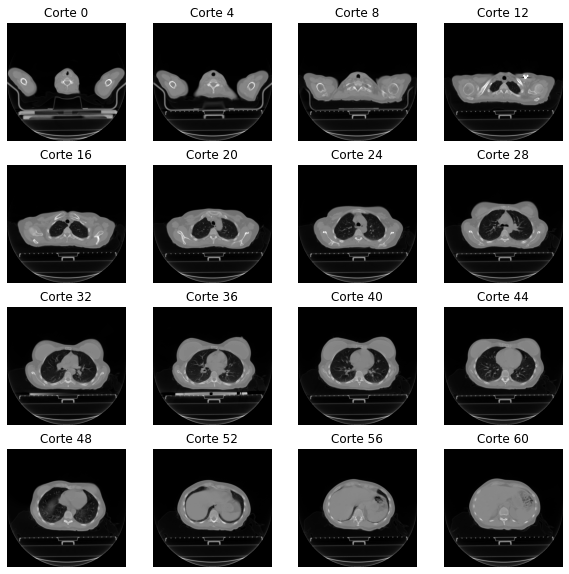

In [4]:
imp.muestra_datos(imagen, 4, 4, 0, 4, -1000, 1000) # visualización de una muestra de los datos

## Crear la imagen de gradiente
Para calcular el gradiente en la imagen se utilizará uno de los filtros de primera derivada más populares, el filtro de Sobel, este filtro será aplicado en la imagen de TC pulmonar original, tanto en dirección horizontal como vertical, luego se obtiene la magnitud del vector de gradiente en un punto mediante la norma euclidiana del vector, que genera la imagen de gradiente.

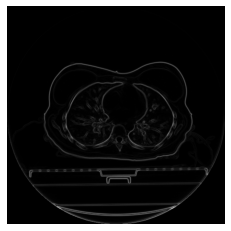

In [5]:
image= imagen[40] # corte numero 40
# aplicamos el operador de sobel en X y Y
sobel_dx = ndimage.sobel(image, 1)
sobel_dy = ndimage.sobel(image, 0)
sobel_gradient = np.hypot(sobel_dx, sobel_dy) # calculamos el norma
sobel_gradient *= 255.0 / np.max(sobel_gradient) # normalizamos
plt.imshow(sobel_gradient, cmap='gray')
plt.axis('off')
plt.show()

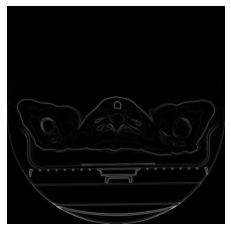

In [6]:
image = imagen[8] # corte numero 8
sobel_gradient = s_p.image_gradiente(image)
plt.imshow(sobel_gradient, cmap='gray')
plt.axis('off')
plt.show()

Para utilizar la segmentación de Watershed basada en marcadores, necesitamos identificar dos marcadores. Un marcador interno, donde se tenga seguridad que dicha zona pertenece a tejido pulmonar y un marcador externo, esta región se caracteriza porque definitivamente está fuera de la región de interés que en este caso son los pulmones. Comenzamos creando el marcador interno mediante el umbral de la imagen y eliminando todas las regiones menos las mas grandes.

## Generación del Marcador interno

El marcador interno se caracteriza por ser una zona donde se tiene certeza de que pertenece a la región que se desea segmentar o región de interés (ROI) que este caso son los pulmones. Para generar el marcador se utiliza los valores respectivos en unidades Hounsfield que corresponden a la zona pulmonar. 
Dado que en las imágenes de TC pulmonar el aire aparecerá con una intensidad media de aproximadamente -1000HU, y que la región pulmonar estará en el rango de -1000HU a -400 HU, mientras que la pared torácica, la sangre y los huesos serán mucho más densos muy por encima de -400 HU. Para especificar los marcadores internos, se seleccionan las regiones con valores de píxeles inferiores a -400 HU. 



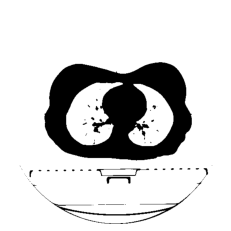

In [7]:
marker_internal = imagen[40] < -400 # evalua si el valor del píxel  cumple o no con la condición
plt.imshow(marker_internal, cmap='gray')
plt.axis('off')
plt.show()

La condición que se aplicó anteriormente genera una matriz booleana, donde todos los elementos que cumplen con la condición tendrán como salida `TRUE` o 1, mientras que los píxeles que no cumplan con la condición tendrán un valor de `FALSE` o 0. Al utilizar la función `plt.imshow` y la paleta de colores `gray` tendremos que para `TRUE` le corresponde el color blanco y para `FALSE` le corresponde el color negro.  Como el fondo de la imagen
es aire tenemos como resultado una imagen con una región que rodea al cuerpo que según la condición aplicada pertenece a la zona de los pulmones, como evidentemente esta zona no representa a  los pulmones procedemos a eliminarla mediante la función  `segmentation.clear_border` de la biblioteca skimage, que borra los objetos conectados al borde de la imagen.

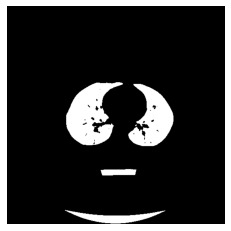

In [8]:
marker_internal = segmentation.clear_border(marker_internal)
plt.imshow(marker_internal, cmap=plt.cm.gray)
plt.axis('off')
plt.show()
#Borrar objetos conectados al borde de la imagen de la etiqueta.

Algunas zonas de la camilla son seleccionadas como región pulmonar por lo que se procede a eliminarlas mediante la función creada anteriormente en `imp.remov_cama`, lo que genera mejores resultados.

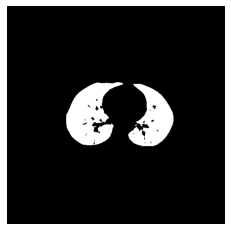

In [9]:
imagen =  imp.remov_cama(imagen, 370, 512) # eliminamos la camilla
marker_internal = imagen[40] < -400 # evalua si el valor del píxel cumple o no con la condición
marker_internal = segmentation.clear_border(marker_internal)
plt.imshow(marker_internal, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

Ahora etiquetamos cada una de los elementos presentes en la imagen, con el fin de identificar todos los elementos en la imagen y poder eliminar la tráquea y otras vías respiratorias.

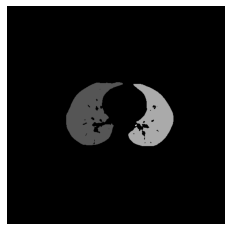

In [10]:
marker_internal_labels = measure.label(marker_internal) # encuentra cada objeto en la imagen y los etiqueta
plt.imshow(marker_internal_labels,  cmap=plt.cm.gray)
plt.axis('off')
plt.show()

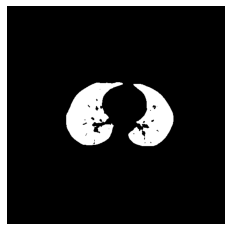

In [11]:
areas = [r.area for r in measure.regionprops(marker_internal_labels)] # Mide las propiedades de las regiones de imágenes etiquetadas.
areas.sort() # ordenamos 
    
if len(areas) > 2: # de los 2 pulmones
    for region in measure.regionprops(marker_internal_labels):
        if region.area < areas[-2]: # el orden logra que solo se escoja los 2 mas grandes (correspondientes a pulomnes)
            for coordinates in region.coords:                
                marker_internal_labels[coordinates[0], coordinates[1]] = 0
                
                

                
marker_internal = marker_internal_labels > 0

plt.imshow(marker_internal,  cmap=plt.cm.gray)
plt.axis('off')
plt.show()

### Tratamiento para imágenes con tráquea

Con la aplicación del código anteriormente se logra eliminar la tráquea, cuando esta tenga una dimensión menor a los pulmones, pero existen cortes en donde esta técnica no retorna buenos resultados y que corresponde a los primeros cortes. Para este caso se tienen 2 opciones, que el corte contenga solamente la tráquea y los pulmones no estén presentes, y donde se encuentren los pulmones y que estos tengan una dimensión menor a la tráquea.

#### Primer caso 

Para el nálisis de este caso se utilizará el corte número 8, en esta sección se encuentra el número de elementos que comprende la imagen, y si es menor que 1 (lo que significa que solamente se detecta la tráquea), procedemos a eliminar el objeto.  

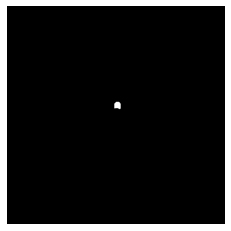

In [12]:
marker_internal1 = imagen[8] < -400 # evalua si el valor del píxel cumple o no con la condición
marker_internal1 = segmentation.clear_border(marker_internal1)
plt.imshow(marker_internal1, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

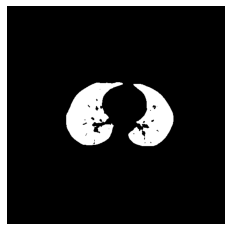

In [13]:
# Para cortes donde solo aparece un elemento (tráquea)
marker_internal_labels = measure.label(marker_internal) # encuentra cada objeto en la imagen y los etiqueta    
areas = [r.area for r in measure.regionprops(marker_internal_labels)] # Mide las propiedades de las regiones de imágenes etiquetadas.
areas.sort() # ordenamos 
    
if len(areas) == 1 and areas[0]< 600: # si solo existe un objeto lo elimina ya que corresponde a la tráquea
    region = measure.regionprops(marker_internal_labels)
    for coordinates in region[0].coords:                
        marker_internal_labels[coordinates[0], coordinates[1]] = 0
marker_internal = marker_internal_labels > 0

plt.imshow(marker_internal,  cmap=plt.cm.gray)
plt.axis('off')
plt.show()        


#### Segundo caso

Para el análisis de este caso utilizaremos el corte número 9, aquí eliminamos el elemento de acuerdo a la posición en la imagen y respecto al tamaño de los objetos, el elemento que se encuentra en el centro y arriba de los otros elementos será eliminado ya que pertenece a la tráquea, por lo que el algoritmo depende de la posición del paciente para su buen funcionamiento.

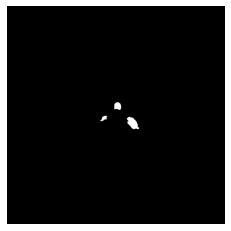

In [14]:
marker_internal = imagen[9] < -400 # evalua si el valor del píxel cumple o no con la condición
marker_internal = segmentation.clear_border(marker_internal)
plt.imshow(marker_internal, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

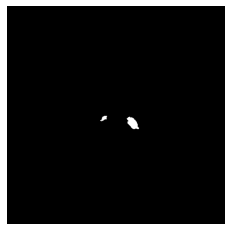

In [15]:
marker_internal_labels = measure.label(marker_internal) # encuentra cada objeto en la imagen y los etiqueta    
areas = [r.area for r in measure.regionprops(marker_internal_labels)] # Mide las propiedades de las regiones de imágenes etiquetadas.
areas.sort() # ordenamos 

# Para cortes donde los pulmones y la tráquea tienen dimensiones similares         
if len(areas) == 3  and areas[0] < 600 and areas[1] < 600 or areas[2] < 600 : # eliminamos la traquea
    regiones = measure.regionprops(marker_internal_labels)
    coordenadas = [r.coords[0][0] for r in measure.regionprops(marker_internal_labels)] 
    coordenadas.sort() # ordenamos
    for region in regiones:
        if region.coords[0][0] < coordenadas[-2]: # el orden logra que solo se escoja los 2 mas grandes (correspondientes a pulomnes)
            for coordinates in region.coords:                
                marker_internal_labels[coordinates[0], coordinates[1]] = 0              
marker_internal = marker_internal_labels > 0
plt.imshow(marker_internal,  cmap=plt.cm.gray)
plt.axis('off')
plt.show()

A continuación se realiza una comparativa entre el código original, y el que implementamos para eliminar la tráquea de los cortes. Cabe destacar que esta técnica solo aplica para cortes cuando la posición del paciente sea HFS (Head First-Supine), con la cabeza primero y con la cara y el torso hacia arriba.

Corte  8


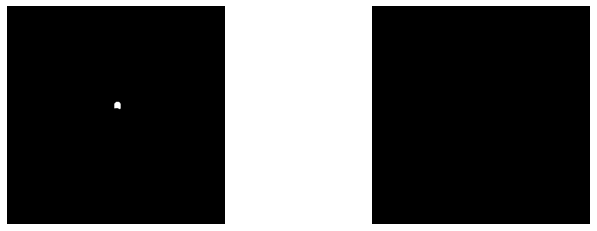

Corte  10


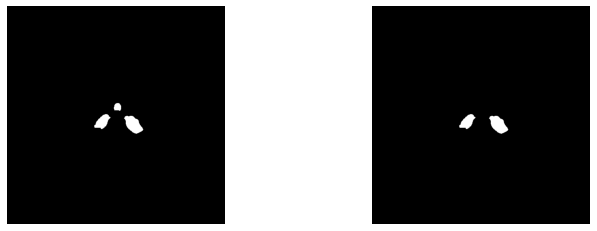

Corte  12


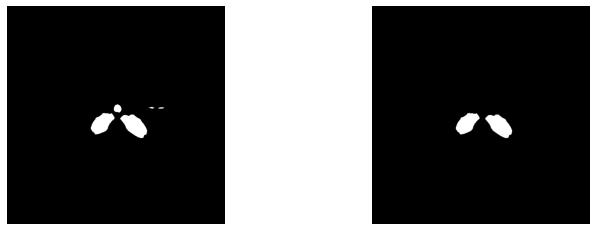

Corte  14


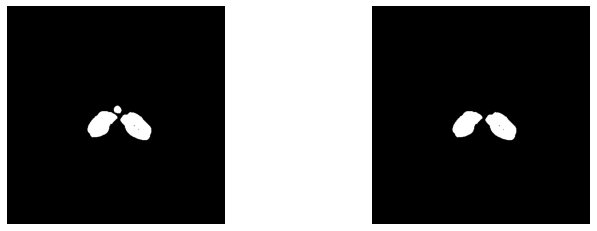

Corte  16


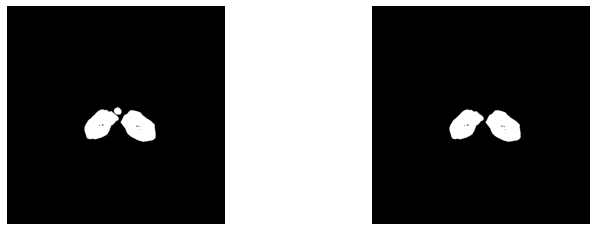

In [16]:
for i in range(8,18,2):
    print('Corte ', i)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    img_traquea = imagen[i]
    marker_internal = imagen[i] < -400 # evalua si el valor del píxel cumple o no con la condición
    marker_internal = segmentation.clear_border(marker_internal)
    ax1.imshow(marker_internal, cmap=plt.cm.gray)
    ax1.axis('off')
    marker_internal = s_p.marcador_interno(img_traquea)
    plt.imshow(marker_internal,  cmap=plt.cm.gray)
    ax2.axis('off')
    plt.show()


## Generación del Marcador Externo
Una vez encontrado el marcador interno de las imágenes procedemos a utilizar su matriz binaria para deducir el marcador externo mediante la dilatación de la matriz mediante dos elementos estructurantes circulares de diferentes proporciones que generaran una franja de al menos 45 píxeles entre cada dilatación.


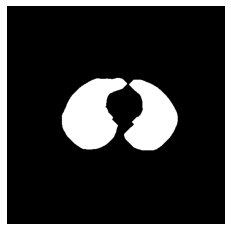

In [17]:
#Creación del marcador externo

# Primera dilatación
marker_internal = s_p.marcador_interno(imagen[40])
external_a = ndimage.binary_dilation(marker_internal, iterations=10) # dilatación
plt.imshow(external_a, cmap='gray')
plt.axis('off')
plt.show()


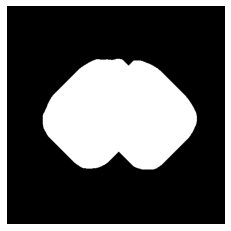

In [18]:
# Segunda  dilatación
external_b = ndimage.binary_dilation(marker_internal, iterations=55) # dilatación
plt.imshow(external_b, cmap='gray')
plt.axis('off')
plt.show()

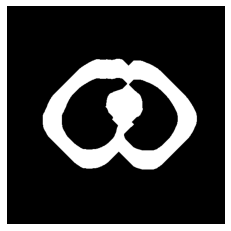

In [19]:
# Marcador Externo
marker_external = external_b ^ external_a
plt.imshow(marker_external, cmap='gray')
plt.axis('off')
plt.show()


### Aplicación del algoritmo Watershed

Para aplicar el algoritmo es necesario definir la zona en que se aplicará. Por el proceso realizado tenemos que el borde del pulmón se encuentra en la  vecindad del marcador interno y del marcador externo, por lo que la aplicación del algoritmo de Watershed será en la tira generada entre ambos marcadores, que llamaremos marcador de Watershed.


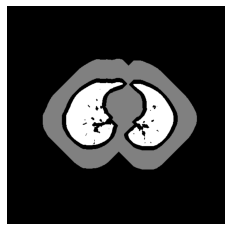

In [20]:
#Creation of the Watershed Marker matrix
marker_watershed = np.zeros((512, 512), dtype=int)
marker_watershed += marker_internal * 255
marker_watershed += marker_external * 128
plt.imshow(marker_watershed, cmap='gray')
plt.axis('off')
plt.show()

Ahora aplicamos la transformación de Watershed de la en la imagen de gradiente con los marcadores encontrado y se encuentra las líneas de watershed correspondientes a los bordes más significativos entre los marcadores (marcador de watershed).

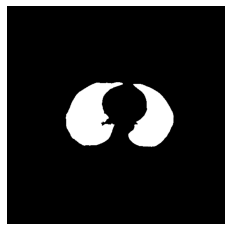

In [21]:
sobel_gradient = s_p.image_gradiente(imagen[40])
watershed = segmentation.watershed(sobel_gradient, marker_watershed)
plt.imshow(watershed, cmap= 'gray')
plt.axis('off')
plt.show()

Encontramos la imagen de gradiente morfológico, que se calcula como la diferencia entre una dilatación y una erosión de la entrada con un elemento estructurante dado.

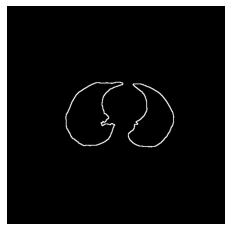

In [22]:
# encontramos la imagen de gradiente
outline = ndimage.morphological_gradient(watershed, size=(3,3))
outline = outline.astype(bool)
plt.imshow(outline, cmap='gray')
plt.axis('off')
plt.show()

La región pulmonar segmentada excluye estructuras densas, como nódulos yuxtapleurales y vasos hiliares, por lo que es necesario suavizar y rellenar las cavidades. En morfología y procesamiento de imágenes digitales, la transformación  Black-Tophat es una operación que se utilizan para extraer pequeños elementos y detalles de imágenes dadas, y se define como la diferecnia entre el closing and la imagen de entrada.

Para no pasar por alto los nódulos ubicados junto a las regiones fronterizas, se realiza una operación de Black-Tophat para volver a incluir esas áreas. Esta es la principal ventaja de este método aquí sobre los otros métodos,  solo las áreas que necesitan reincorporación se dilatan, en todas partes el borde del pulmón permanece preciso.


In [23]:
# Realizamos el Black-Hat
blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                    [0, 1, 1, 1, 1, 1, 0],
                    [1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1],
                    [0, 1, 1, 1, 1, 1, 0],
                    [0, 0, 1, 1, 1, 0, 0]]
# creamos el elemento estructurante
blackhat_struct = ndimage.iterate_structure(blackhat_struct, 6)

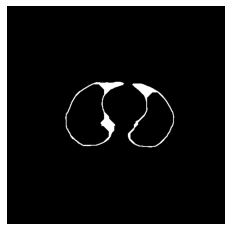

In [24]:
outline += ndimage.black_tophat(outline, structure = blackhat_struct)
#Use the internal marker and the Outline that was just created to generate the lungfilter
plt.imshow(outline, cmap='gray')
plt.axis('off')
plt.show()

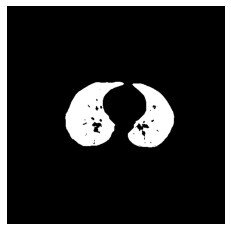

In [25]:
lungfilter = np.bitwise_or(marker_internal, outline) # compara dos matrices, y si hay almenos un uno la salida es 1
plt.imshow(lungfilter, cmap='gray')
plt.axis('off')
plt.show()

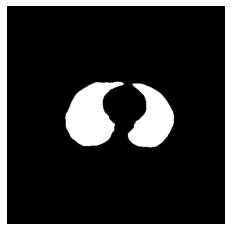

In [26]:
# Cierre de los orificios en el filtro pulmonar

lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
plt.imshow(lungfilter, cmap='gray')
plt.axis('off')
plt.show()
    


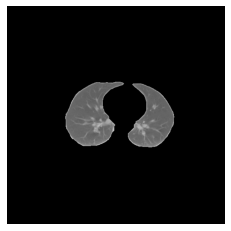

In [27]:
#Reemplazamos las zonas con valor de 1 con los valores de la imagen original

segmented = np.where(lungfilter == 1, imagen[40], -2000*np.ones((512, 512)))
plt.imshow(segmented, cmap='gray')
plt.axis('off')
plt.show()

## Aplicación del algoritmo a un examen completo.
 
El proceso en este punto es repetitivo para cada uno de los cortes por lo que se utilizará el módulo `segmentacion_pulmonar.py` importado como  `s_p` y el módulo  **`imprimir_imagen`** y es importado  como **`imp`**, para representar las imágenes. 

La muestra contiene un total de : (75, 512, 512) cortes.


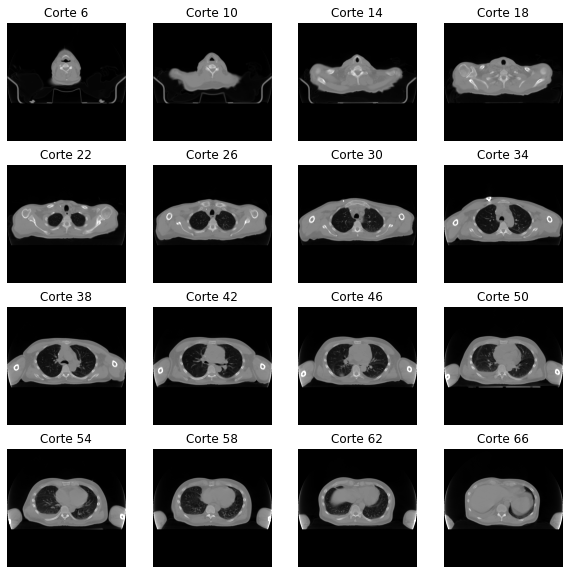

In [28]:
ruta = 'datos-torax-A/paciente6-A' # ruta de la imagen
imagen = imp.remov_cama(imp.extrac_matrix(imp.load_scan(ruta))) # cargamos las imágenes y extraemos la matriz
print('La muestra contiene un total de :', imagen.shape,'cortes.')
imp.muestra_datos(imagen, 4, 4, 6, 4, -1000, 1000)

In [ ]:
image_seg = s_p.seg_examen(ruta, 6)

In [ ]:
imp.muestra_datos(image_seg, 4, 4, 6, 4, np.min(image_seg), np.max(image_seg)) # visualización

In [ ]:
carpeta = 'array_seg_pulmonar'
paciente = 'paciente6'
imp.guardar_arrays(carpeta, paciente, image_seg )
array_imagen_seg = np.load(carpeta + '/'+'{}.npy'.format('paciente6')) # cargamos la matriz    

In [ ]:
print('La imagen de pulmones segmentados fue guardada en un archivo en formato ', type(array_imagen_seg)) 

[Top of Page](#top)
<img style="float: right;" src="https://fisica.epn.edu.ec/images/LOGO_fisica-01-01.png" alt="Space Telescope Logo" width="300px"/> 